# 시작

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import imageio, glob

# 데이터 불러오기 & 확인 & 전처리

In [2]:
C_PATH = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10'

def load_lms_data():
    (train_x,_), (test_x,_) = tf.keras.datasets.fashion_mnist.load_data()
    train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
    return train_x, test_x
    
    
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    print('{}개 훈련 데이터, {}개 시험 데이터를 불러왔습니다'.format(len(train_x), len((test_x))))
    print('훈련데이터: {}'.format(train_x.shape))
    print('시험데이터: {}'.format(test_x.shape))
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(train_x, train_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
        print('{} 데이터만 선택합니다'.format(label))
        print('훈련데이터: {}'.format(train_x.shape))
        print('시험데이터: {}'.format(test_x.shape))
    return train_x, test_x


def preprocess_data(data):
    '''
    입력 데이터를 -1~1의 값으로 수정한다
    '''
    '''
    mean = np.mean(data, axis=tuple(range(data.ndim-1)))
    mean = np.expand_dims(mean, axis=0)
    std = np.std(data, axis=tuple())
    data = (data-mean)/std
    '''
    data = (data-127.5)/127.5
    #data = data/255
    return data


def draw_data(data, row=5, col=5):
    '''
    데이터 원본을 무작위로 row*col갯수만큼 그린다
    '''
    plt.figure(figsize=(10,10))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        n = np.random.randint(data.shape[0])
        plt.imshow(data[n])
        plt.axis('off')
    plt.show()

# 모델 생성

In [3]:
INPUT_SIZE = 128

In [4]:
def make_lms_generator_model():
    '''
    LMS 생성자 모델
    '''

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(INPUT_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    return model


def make_lms_discriminator_model():
    '''
    LMS 판별자 모델
    '''
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

## 모델1: LMS의 모델 수정

In [5]:
def make_generator_model1():
    '''
    생성자 모델
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(INPUT_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model


def make_discriminator_model1():
    '''
    판별자 모델
    '''
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## 모델2: 검색한 모델

In [6]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

def make_generator_model2():
    '''
    생성자 모델
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(INPUT_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model


def make_discriminator_model2():
    '''
    판별자 모델
    '''
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# 모델 훈련

In [7]:
BATCH_SIZE = 128

In [19]:
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake):    
    return LOSS(tf.ones_like(fake), fake)


def discriminator_loss(real, fake):
    fake_loss = LOSS(tf.zeros_like(fake), fake)
    real_loss = LOSS(tf.ones_like(real), real)
    return fake_loss+real_loss


def discriminator_accuracy(real, fake):
    base = tf.constant([0.5])
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake, base), tf.float32))
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real, base), tf.float32))
    return real_accuracy, fake_accuracy


@tf.function
def train_step(generator, gen_opt, discriminator, dis_opt, real_images):
    noise = tf.random.normal([BATCH_SIZE, INPUT_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        fake_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
                
        real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)
    
    gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    dis_gradient = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables)) 
    dis_opt.apply_gradients(zip(dis_gradient, discriminator.trainable_variables))
    
    return gen_loss, dis_loss, real_acc, fake_acc

# 시각화 & 저장

In [9]:
def draw_samples(samples, row=4, col=4, file=None):
    '''
    생성된 이미지를 그린다
    file(str)이 있다면 파일에 저장한다
    '''
    vmin = tf.math.reduce_min(samples)
    vmax = tf.math.reduce_max(samples)
    plt.figure(figsize=(10,10))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        if vmin < 0:
            plt.imshow(tf.cast((samples[i]*127.5)+127.5, tf.uint8))
        else:
            plt.imshow(samples[i])
        plt.axis('off')
    if file:
        path = os.path.join(C_PATH, 'generated_samples')
        plt.savefig(os.path.join(path, file))
    plt.show()
    
    
def draw_train_history(history, file=None):  
    '''
    학습 과정을 그린다
    file(str)이 있다면 파일에 저장한다
    '''
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['dis_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'dis_loss'], loc='upper left')  

    plt.subplot(212)  
    plt.plot(history['real_accuracy'])
    plt.plot(history['fake_accuracy'])    
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    if file:
        path = os.path.join(C_PATH, 'training_history')
        plt.savefig(os.path.join(path, file))
    plt.show()
    
    
def make_gif():
    anim_file = os.path.join(C_PATH, 'cifar10_dcgan.gif')
    with imageio.get_writer(anim_file, mode='I') as writer:
        image_path = os.path.join(C_PATH, 'generated_samples')
        filenames = glob.glob(image_path + '/sample*.png')
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

# 최종 사용 함수

In [10]:
def train(generator, gen_opt, discriminator, dis_opt, dataset, epochs, seed, load_checkpoint=False):

    history = {'gen_loss':[],'dis_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                     discriminator_optimizer=dis_opt,
                                     generator=generator,
                                     discriminator=discriminator)
    checkpoint_path = os.path.join(C_PATH, 'training_checkpoints')
    if load_checkpoint:
        latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
        checkpoint.restore(latest_checkpoint)
        generator = checkpoint.generator
        discriminator = checkpoint.discriminator
        t_images = generator(seed, training=False)
        print('latest checkpoint loaded')
        draw_samples(t_images)
    for epoch in range(epochs):
        for i, images in enumerate(dataset):
            gen_loss, dis_loss, real_acc, fake_acc = train_step(generator, gen_opt, discriminator, dis_opt, images)
            history['gen_loss'].append(gen_loss)
            history['dis_loss'].append(dis_loss)
            history['real_accuracy'].append(real_acc)
            history['fake_accuracy'].append(fake_acc)
            if (i%50)==0:
                display.clear_output(wait=True)
                g_image = generator(seed, training=False)
                image_file = 'sample_e{:05d}_i{:06d}'.format(epoch, i)
                print('e{}_i{}'.format(epoch, i))
                draw_samples(g_image, file=image_file)
        if (epoch + 1) % 50 == 0:
            checkpoint_path = os.path.join(C_PATH, 'training_checkpoints')
            checkpoint.save(file_prefix=os.path.join(checkpoint_path, 'ckpt'))
        history_file = 'history_e{:05d}'.format(epoch)
        draw_train_history(history, file=history_file)

# 메인

학습에 시간이 오래 걸리므로 적합한 모델을 찾기까지 cifar10 데이터 중 자동차만 다뤄본다

## 자동차 이미지만 이용

In [76]:
train_x, test_x = load_data(label=1)

50000개 훈련 데이터, 10000개 시험 데이터를 불러왔습니다
훈련데이터: (50000, 32, 32, 3)
시험데이터: (10000, 32, 32, 3)
1 데이터만 선택합니다
훈련데이터: (5000, 32, 32, 3)
시험데이터: (460, 32, 32, 3)


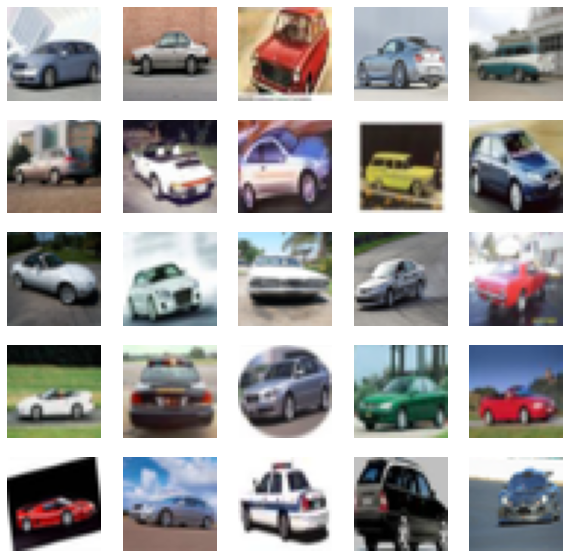

In [77]:
draw_data(train_x)

In [78]:
train_x = preprocess_data(train_x)

In [79]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_x.shape[0]).batch(BATCH_SIZE)

In [80]:
NUM_PIC = 16
seed = tf.random.normal([NUM_PIC, INPUT_SIZE])
seed.shape

TensorShape([16, 128])

## LMS 모델의 수정본으로 학습시킨 결과

In [89]:
generator = make_generator_model1()
generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16384)             2097152   
_________________________________________________________________
batch_normalization_25 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 8, 8, 128)       

In [90]:
discriminator = make_discriminator_model1()
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)            

e999_i0


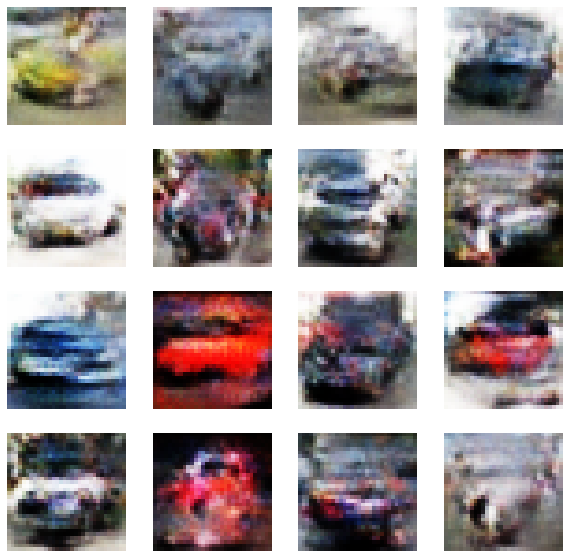

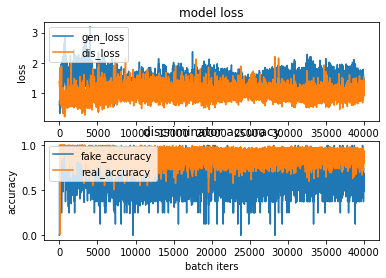

In [93]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

train(generator, gen_opt, discriminator, dis_opt, train_dataset, 1000, seed, load_checkpoint=False)

Loss나 Accuracy의 그래프 폭이 크고, 1000 epoch동안 자동차 모양을 생성해내지는 못한다.   
자동차의 바퀴나, 형태정도는 표현해내는 것이 보인다.   

## 검색한 모델로 학습 시킨 결과

검색한 모델의 가장 큰 차이점은 아래 두 가지이다.
1. 학습률을 높이고 LeakyReLU에 alpha값을 적용하였다.   
2. 또, 생성 모델에 마지막을 Conv2D를 사용하여 직전까지 Conv2DTranspose한 것들을 종합하여 이미지를 생성하였다.

In [84]:
generator = make_generator_model2()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4096)              524288    
_________________________________________________________________
batch_normalization_21 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 8, 8, 128)       

In [85]:
discriminator = make_discriminator_model2()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 256)       

e999_i0


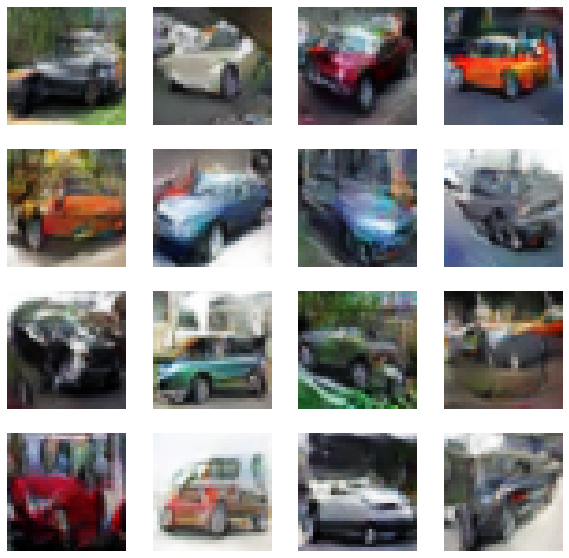

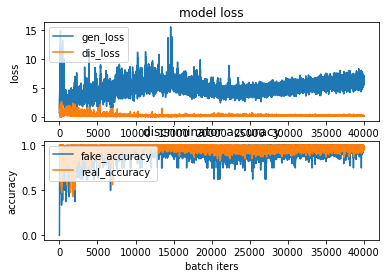

In [88]:
gen_opt = tf.keras.optimizers.Adam(2e-4)
dis_opt = tf.keras.optimizers.Adam(2e-4)

train(generator, gen_opt, discriminator, dis_opt, train_dataset, 1000, seed, load_checkpoint=False)

첫 모델에 비해 loss나 accuracy의 변화 폭이 작으며, 실제 생성된 이미지도 자동차에 가깝다.   

## 전체 이미지를 이용

In [11]:
train_x, test_x = load_data()

50000개 훈련 데이터, 10000개 시험 데이터를 불러왔습니다
훈련데이터: (50000, 32, 32, 3)
시험데이터: (10000, 32, 32, 3)


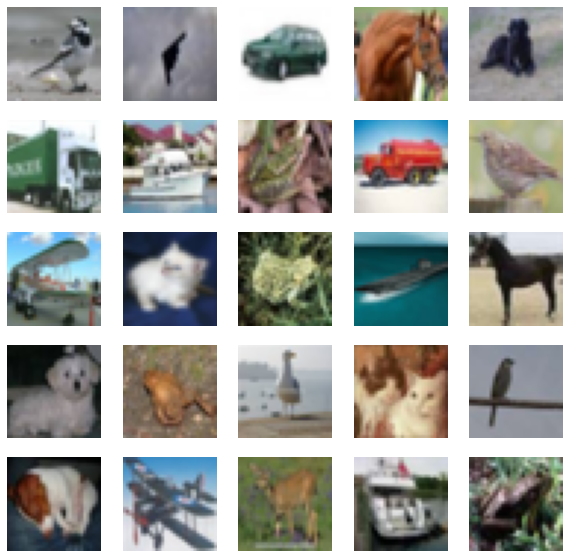

In [12]:
draw_data(train_x)

In [13]:
train_x = preprocess_data(train_x)

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_x.shape[0]).batch(BATCH_SIZE)

In [15]:
NUM_PIC = 16
seed = tf.random.normal([NUM_PIC, INPUT_SIZE])
seed.shape

TensorShape([16, 128])

## LMS 모델의 수정본으로 학습시킨 결과

In [16]:
generator = make_generator_model1()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             2097152   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [17]:
discriminator = make_discriminator_model1()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8193      
Total params: 217,985
Trainable params: 217,985
Non-trainable params: 0
________________________________________________

e499_i350


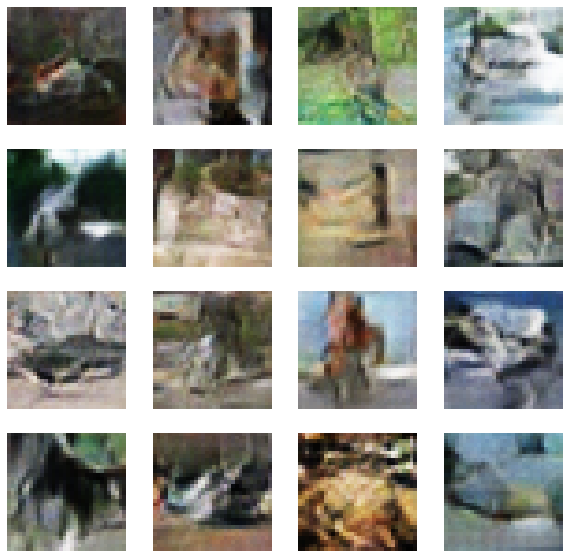

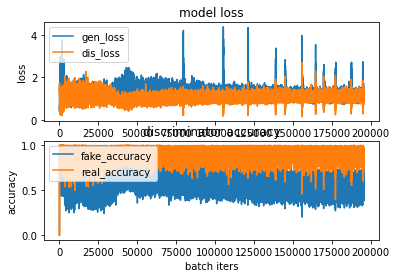

In [18]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

train(generator, gen_opt, discriminator, dis_opt, train_dataset, 500, seed, load_checkpoint=False)

## 검색한 모델로 학습 시킨 결과

In [20]:
generator = make_generator_model2()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [21]:
discriminator = make_discriminator_model2()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)        

e499_i350


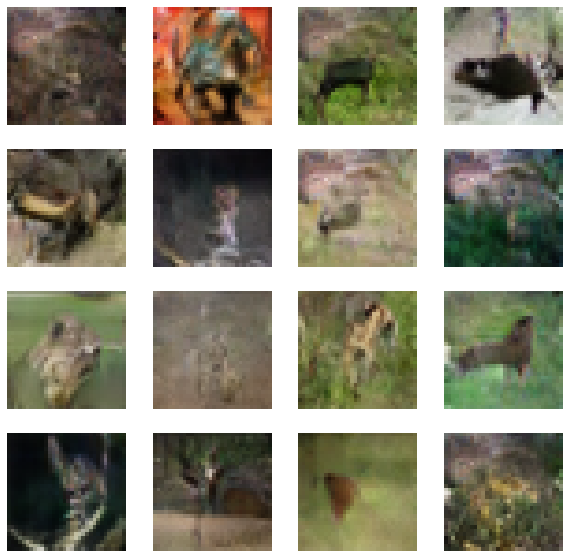

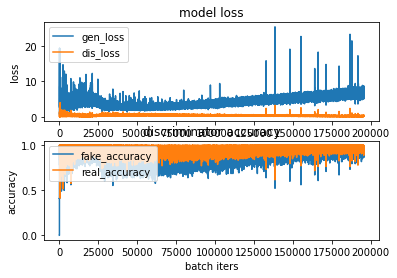

In [22]:
gen_opt = tf.keras.optimizers.Adam(2e-4)
dis_opt = tf.keras.optimizers.Adam(2e-4)

train(generator, gen_opt, discriminator, dis_opt, train_dataset, 500, seed, load_checkpoint=False)

전반적으로 첫번째 모델의 loss나 accuracy가 더 좋지만, 두번째 모델의 이미지가 형체가 더 구체적이다.   
학습이 진행됨에 따라 먼저 선명한 모습을 보였다가 흐려지는 이미지가 있고, 그보다 더 늦게 선명한 모습을 보이는 이미지가 있다.   
아래는 400 epoch에 생성된 이미지인데, 몇몇 이미지는 500 epoch때 이미지보다 선명하고, 다른 몇몇 이미지는 더 흐려져있다.

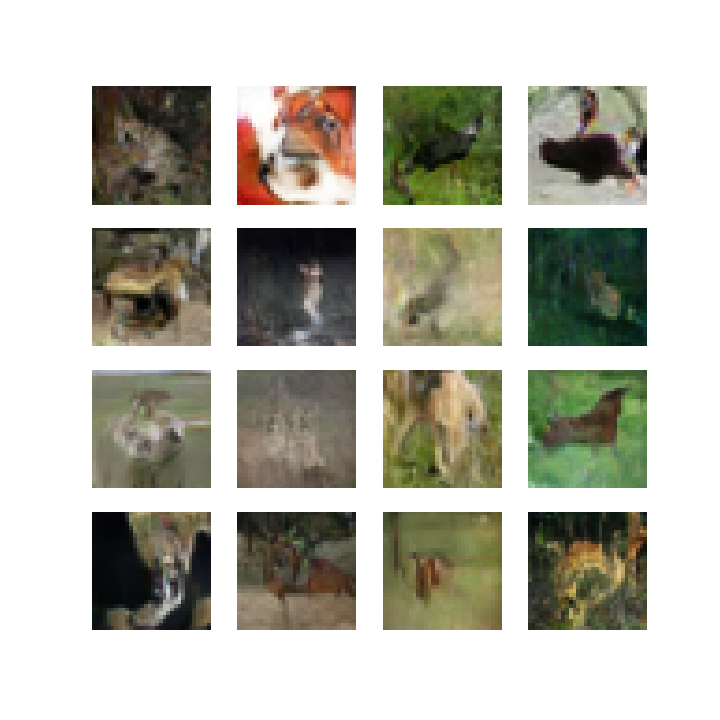

In [28]:
result_path = os.path.join(C_PATH, 'generated_samples')
display.Image(filename=os.path.join(result_path, 'sample_e00400_i000000.png'))

# 결론

자동차 한가지에 대해 생성한 이미지는 꽤 알아볼 수 있었던 반면 cifar10이미지를 모두 사용한 경우에서는 세부 내용은 거의 묘사하지 못했다.   
판단 기준이 참, 거짓이므로 여러 이미지가 섞여 있는 경우 생성해내기가 훨씬 어려운 듯 보인다.   
또, 여러 방법으로 시험해 본 결과 합성곱 층을 하나 더 추가하였을 때 이미지는 비교적 구체화 되었으나, 학습 시간의 증가폭이 매우 컸다.   
두번째로 사용한 모델이 학습 시간의 증가폭이 비교적 작아 최종적으로 사용하였다.   